In [75]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [25]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

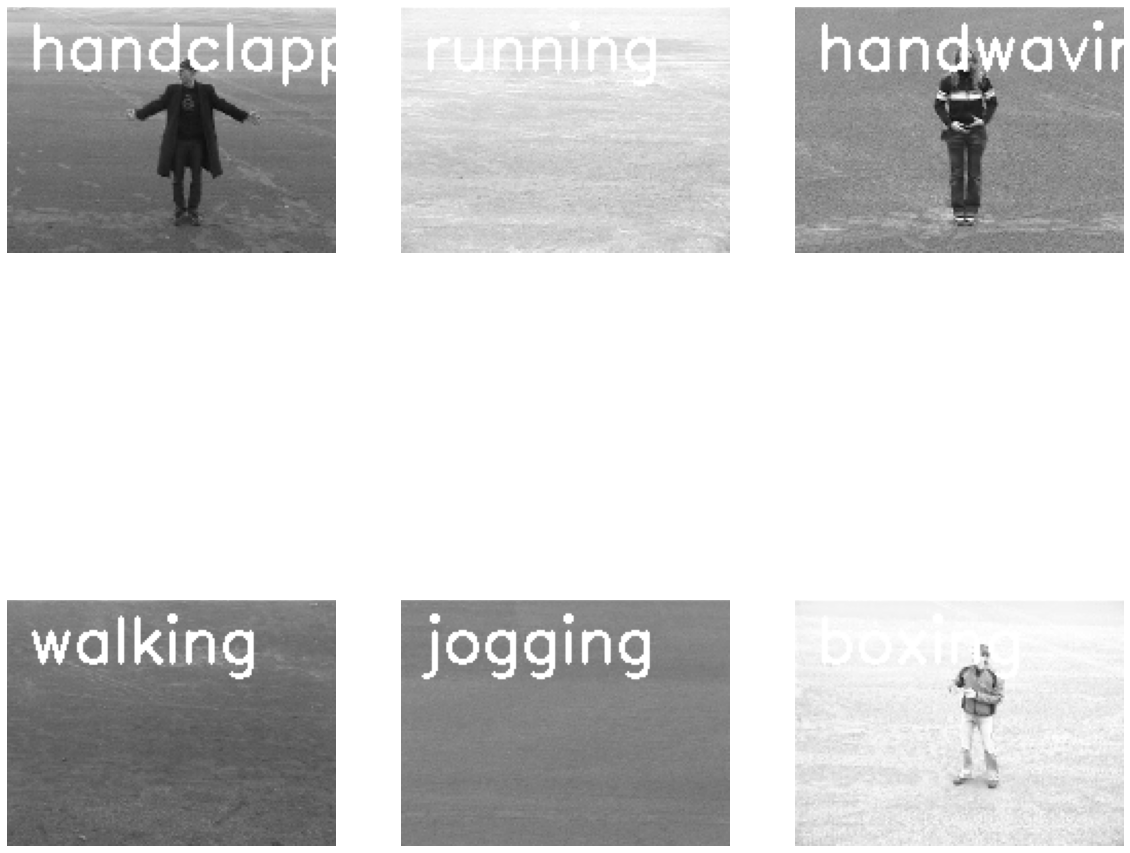

In [125]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('/human-activity-recognition-from-video/Data')
random_range = random.sample(range(len(all_classes_names)), 6)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/human-activity-recognition-from-video/Data/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/human-activity-recognition-from-video/Data/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(2, 3, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [26]:
class preprocess:
    
    def __init__(self, path,image_size,sequence_length):
        self.path = path
        self.image_size = image_size
        self.sequence_length = sequence_length
        
    def frames_extraction(self, video_path):
        frames_list = []
        video_reader = cv2.VideoCapture(video_path)
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count/self.sequence_length), 1)

        for frame_counter in range(self.sequence_length):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) #making the system read only the above 10 frames 
            success, frame = video_reader.read() 

            if not success:
                break

            resized_frame = cv2.resize(frame, (self.image_size, self.image_size)) 
            normalized_frame = resized_frame / 255
            frames_list.append(normalized_frame)

        video_reader.release()

        return frames_list
    
    def create_dataset(self):
        
        CLASSES_LIST = os.listdir(self.path)
        features = []
        labels = []
        video_files_paths = []

        for class_index, class_name in enumerate(CLASSES_LIST):
            files_list = os.listdir(os.path.join(self.path, class_name))

            for file_name in files_list:            
                video_file_path = os.path.join(self.path, class_name, file_name)
                frames = self.frames_extraction(video_file_path)

                if len(frames) == self.sequence_length:
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

        features = np.asarray(features)
        labels = np.array(labels)  

        return features, labels, CLASSES_LIST
    
    def encoding_target(self):
        _,labels,_ = self.create_dataset()
        one_hot_encoded_labels = to_categorical(labels)
        return one_hot_encoded_labels
    
    def split_data(self):
        features,_,_ = self.create_dataset()
        one_hot_encoded_labels = self.encoding_target()
        print("Spliting data....")
        features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)
        return features_train, features_test, labels_train, labels_test
    
    def necassary_datas(self):
        features_train, features_test, labels_train, labels_test = self.split_data()
        _,_,CLASSES_LIST = self.create_dataset()
        
        return features_train, features_test, labels_train, labels_test,CLASSES_LIST

        

In [27]:
path = '/human-activity-recognition-from-video/Data'
preprocess1 = preprocess(path,64, 20)

In [28]:
features_train, features_test, labels_train, labels_test,CLASSES_LIST = preprocess1.necassary_datas()

Spliting data....


In [111]:
def model_building():
    model = Sequential()    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (seq_length, image_size, image_size, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25))) 
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))               
    model.add(LSTM(32,return_sequences = True))
    model.add(LSTM(64,return_sequences = False))
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    model.summary()
    
    return model

In [112]:
image_size = 64

seq_length = 20
model = model_building() 

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_133 (TimeDi (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_134 (TimeDi (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_135 (TimeDi (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_136 (TimeDi (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_137 (TimeDi (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_138 (TimeDi (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_139 (TimeDi (None, 20, 4, 4, 64)    

In [113]:
def plot(model_training_history, metric_name_1, metric_name_2, plot_name):
  
    metric_value_1 = model_training_history.history.history[metric_name_1]
    metric_value_2 = model_training_history.history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

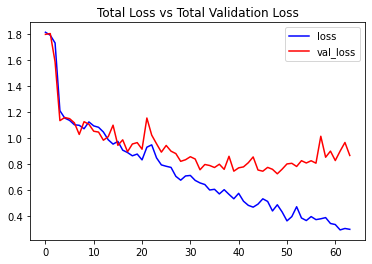

In [114]:
plot(model,'loss','val_loss', 'Total Loss vs Total Validation Loss')

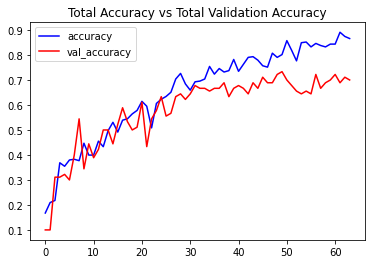

In [115]:
plot(model, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [116]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 [==============================] - 0s 18ms/step - loss: 0.9316 - accuracy: 0.6067


In [141]:
def predict(path):
    frames_list = []
    video_reader = cv2.VideoCapture(path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/20), 1)
    for frame_counter in range(20):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) #making the system read only the above 10 frames 
        success, frame = video_reader.read() 

        resized_frame = cv2.resize(frame, (image_size,image_size)) 
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    plt.imshow(frames_list[2])
    video_reader.release()
    features = np.asarray(frames_list)
    prediction = LRCN_model.predict(np.expand_dims(features, axis = 0))
    predicted_label = np.argmax(prediction[0])
    predicted_class_name = CLASSES_LIST[predicted_label]
    plt.title(f"Prediction:  {predicted_class_name}", fontsize =20)
    return 

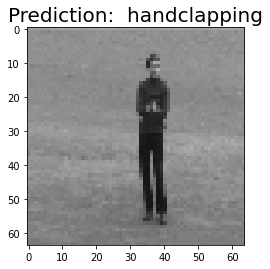

In [142]:
predict('/human-activity-recognition-from-video/Data/handclapping/person01_handclapping_d1_uncomp.avi')

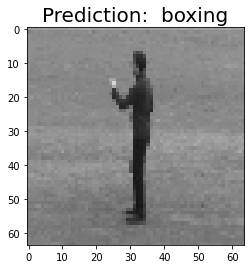

In [143]:
predict('/human-activity-recognition-from-video/Data/boxing/person01_boxing_d1_uncomp.avi')

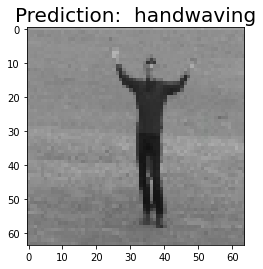

In [144]:
predict('/human-activity-recognition-from-video/Data/handwaving/person01_handwaving_d1_uncomp.avi')